In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [2]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl"); print(allclusters.shape)
allclusters = allclusters[allclusters['column_maxes'].map(len) > 5].reset_index(drop=True); print(allclusters.shape) # current: 15

(438575, 27)
(87273, 27)


In [3]:
masses = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/picky+match.csv')

In [4]:
maxes = allclusters['column_maxes'].values

In [5]:
normalised = []

for signal in maxes:
    minimum = np.min(signal)
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print('Error: Max not greater than min in signal.')
    normalised.append(normalised_signal)

allclusters['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; allclusters['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; allclusters['maxdiff'] = maxdiff

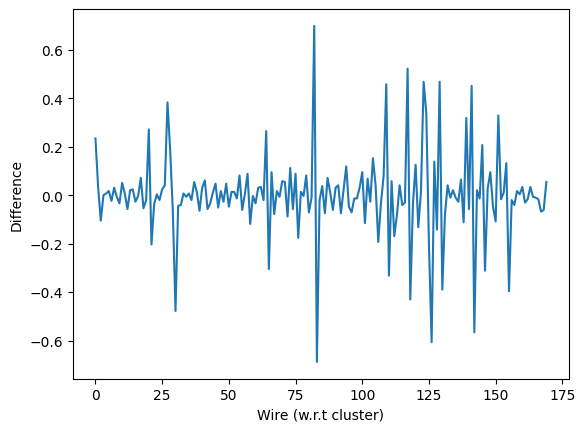

In [6]:
plt.plot(adcdiff[0]); plt.ylabel('Difference'); plt.xlabel('Wire (w.r.t cluster)')
plt.show()

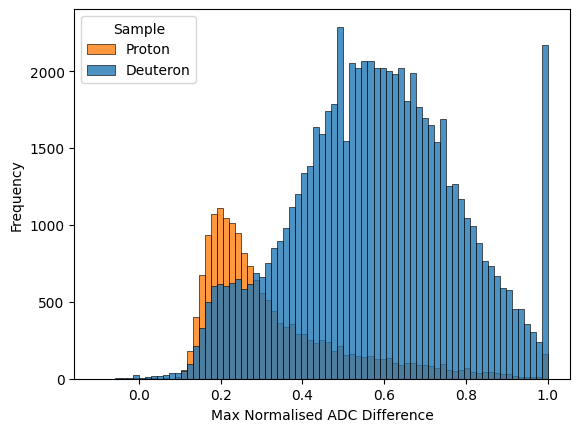

In [ ]:
plt.figure()

sns.histplot(
    data=allclusters,
    x='maxdiff',
    hue='particle_type',
    bins='auto',
    alpha=0.8
)


plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')

# Change legend labels
plt.legend(title='Sample', labels=['Proton', 'Deuteron'])

plt.show()

Finding cleanest samples

In [117]:
cleanclusters = allclusters[allclusters['maxdiff'] <= 0.26].reset_index(drop=True)

In [118]:
masses

,run,subrun,event,p,m,beamline_mass
0,8675,12,1249,0,1,1082.48
1,8675,12,1250,0,0,120.62
2,8675,12,1256,0,1,893.74
3,8675,12,1257,1,0,180.31
4,8675,12,1258,1,1,-327.26
...,...,...,...,...,...,...
580633,9781,133,21593,0,1,1008.86
580634,9781,133,21596,0,1,1212.37
580635,9781,133,21614,0,0,951.96
580636,9781,133,21621,0,0,462.36


In [119]:
cleanclusters = pd.merge(
    cleanclusters,
    masses[['run', 'subrun', 'event', 'p', 'm', 'beamline_mass']],
    on=['run', 'subrun', 'event'],
    how='left'
)

In [ ]:
# overlap = []

print(cleanclusters.shape)

for idx, diff in enumerate(cleanclusters['adcdiff'].values):
    for i in range(5, len(diff[i] < -0.4)):

            # cluster = cleanclusters['normalised'][idx]
            # signal = cluster[:i + 1]
            # noise = signal[i + 1:]

            # overlap.append({
            #     'index': idx,
            #     'split_point': i,
            #     'signal': signal,
            #     'noise': noise
            # })

            cleanclusters = cleanclusters.drop(idx)
            break

cleanclusters = cleanclusters.reset_index(drop=True); print(cleanclusters.shape)

# print(f"Found {len(overlap)} events with large negative decreases.")

(12822, 33)
(12655, 33)


In [121]:
# TODO: Remove clusters in unusual locations
# TODO: Remove clusters that are too big in height (bad cases)

In [122]:
deuterons = cleanclusters[(cleanclusters['particle_type'] == 'deuteron') & (cleanclusters['plane'] == 'collection')]
protons = cleanclusters[(cleanclusters['particle_type'] == 'proton') & (cleanclusters['plane'] == 'collection')]

In [123]:
deuteronscount = deuterons.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)
protonscount = protons.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

In [124]:
deuteron_interest = cleanclusters[(cleanclusters['plane'] == 'collection') & (cleanclusters['height'] < 20) & (cleanclusters['particle_type'] == 'deuteron') & (cleanclusters['bbox_min_row'] < 120) & (cleanclusters['beamline_mass'] > 1750) & (cleanclusters['beamline_mass'] < 1950)]; print(len(deuteron_interest))
proton_interest = cleanclusters[(cleanclusters['plane'] == 'collection') & (cleanclusters['height'] > 30) & (cleanclusters['height'] < 50) & (cleanclusters['particle_type'] == 'proton')]; print(len(proton_interest))

56
1206


In [125]:
sumADC = [np.sum(cluster, axis=1)[:-1] for cluster in cleanclusters['image_intensity'].values]; cleanclusters['energy'] = sumADC
residual_range = [list(range(len(cluster)-1, -1, -1)) for cluster in cleanclusters['energy'].values]; cleanclusters['rr'] = residual_range

In [126]:
# cleanclusters.to_pickle('/Users/user/data/research/proton-deuteron/csv/final.pkl')

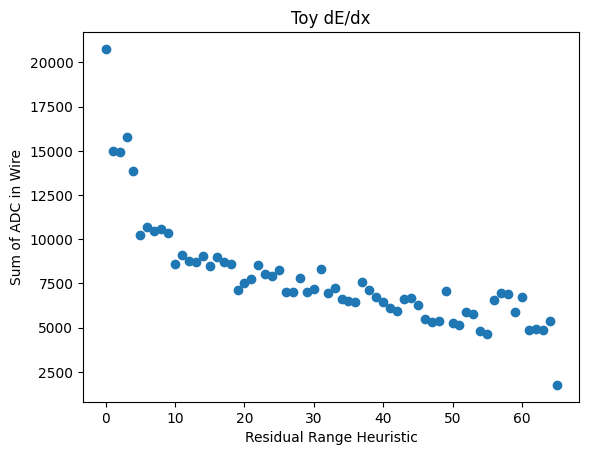

In [127]:
dedx = cleanclusters[['energy', 'rr']]
i=355
plt.scatter(dedx['rr'][i], dedx['energy'][i]); plt.ylabel('Sum of ADC in Wire'); plt.xlabel('Residual Range Heuristic'); plt.title('Toy dE/dx'); plt.show()

In [128]:
normalised_e = []
for energy in cleanclusters['energy']:
    minimum = np.min(energy)
    maximum = np.max(energy)

    if maximum > minimum:
        normalised = (energy - minimum) / (maximum - minimum)
    else:
        normalised = np.zeros_like(energy, dtype=float)

    normalised_e.append(normalised)

cleanclusters['normalised_e'] = normalised_e

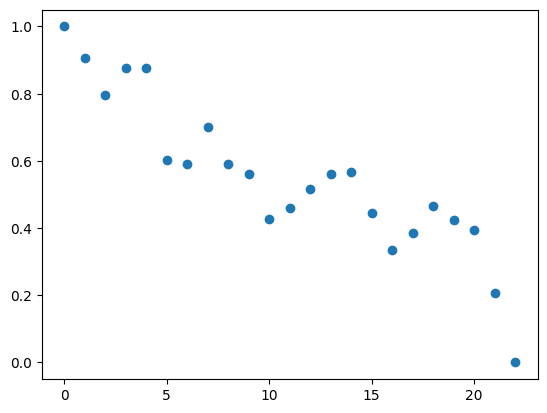

In [130]:
dedx = cleanclusters[['normalised_e', 'rr']]
i=675
plt.scatter(dedx['rr'][i], dedx['normalised_e'][i])

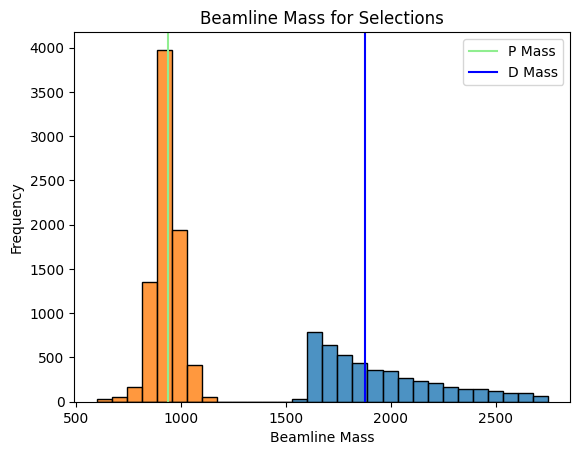

In [131]:
plt.figure()

sns.histplot(data=cleanclusters,
             x='beamline_mass',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

plt.axvline(938, color='lightgreen', label='P Mass')
plt.axvline(1876, color='blue', label='D Mass')

plt.xlabel('Beamline Mass')
plt.ylabel('Frequency')
plt.title('Beamline Mass for Selections')
plt.legend()
plt.show()

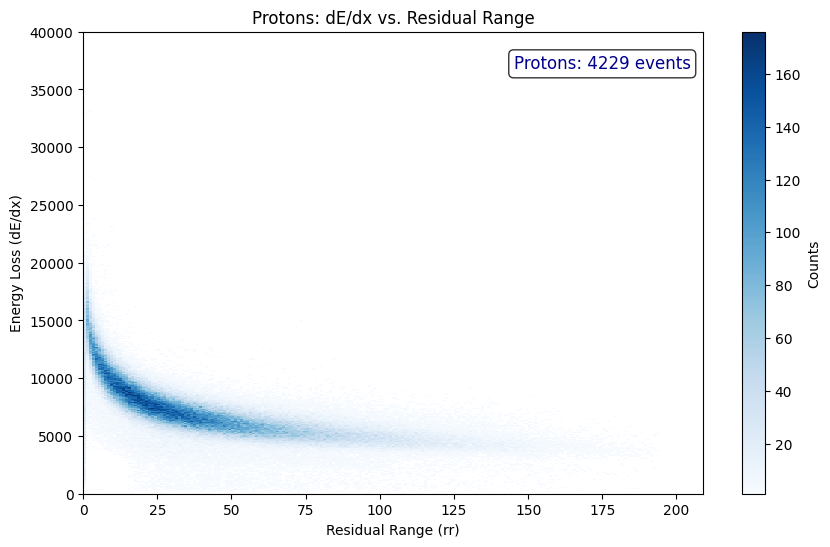

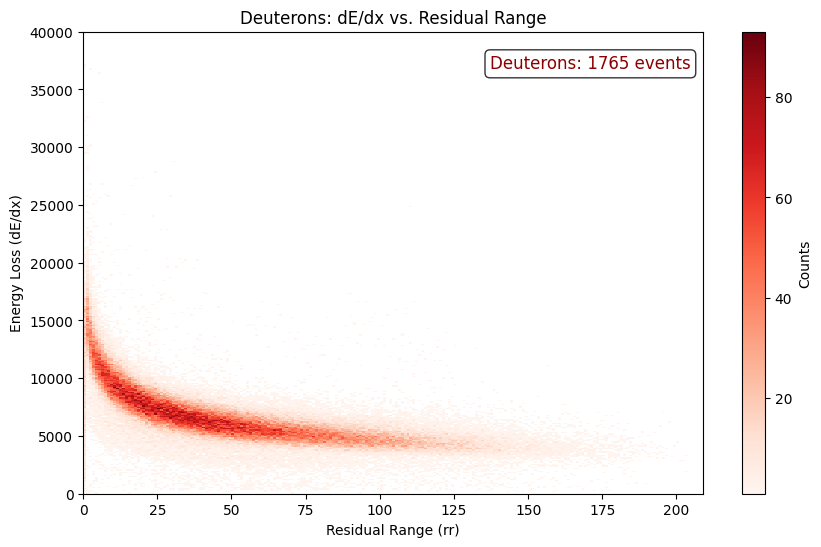

In [165]:
# Filter for protons and deuterons
protons = cleanclusters[(cleanclusters['particle_type'] == 'proton') & (cleanclusters['plane'] == 'collection')]
deuterons = cleanclusters[(cleanclusters['particle_type'] == 'deuteron') & (cleanclusters['plane'] == 'collection')]

coll = cleanclusters[cleanclusters['plane'] == 'collection']
protons = coll[(coll['particle_type'] == 'proton') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]
deuterons = coll[(coll['particle_type'] == 'deuteron') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]

# Concatenate rr and energy values for protons
rr_protons = np.concatenate(protons['rr'].values)
energy_protons = np.concatenate(protons['energy'].values)

# Concatenate rr and energy values for deuterons
rr_deuterons = np.concatenate(deuterons['rr'].values)
energy_deuterons = np.concatenate(deuterons['energy'].values)

# Create 2D histogram for protons
plt.figure(figsize=(10, 6))
hist_protons = plt.hist2d(
    rr_protons,
    energy_protons,
    bins=(194, 693),
    cmap='Blues',
    cmin=1  # Minimum count to display
)
plt.xlim(0, 209)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (rr)')
plt.ylabel('Energy Loss (dE/dx)')
plt.title('Protons: dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'Protons: {len(protons)} events', transform=plt.gca().transAxes, 
         fontsize=12, color='darkblue', ha='right', va='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.ylim(0, 40000)
plt.show()

# Create 2D histogram for deuterons
plt.figure(figsize=(10, 6))
hist_deuterons = plt.hist2d(
    rr_deuterons,
    energy_deuterons,
    bins=(204, 572),
    cmap='Reds',
    cmin=1  # Minimum count to display
)
plt.xlim(0, 209)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (rr)')
plt.ylabel('Energy Loss (dE/dx)')
plt.title('Deuterons: dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'Deuterons: {len(deuterons)} events', transform=plt.gca().transAxes, 
         fontsize=12, color='darkred', ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.ylim(0, 40000)
plt.show()

693

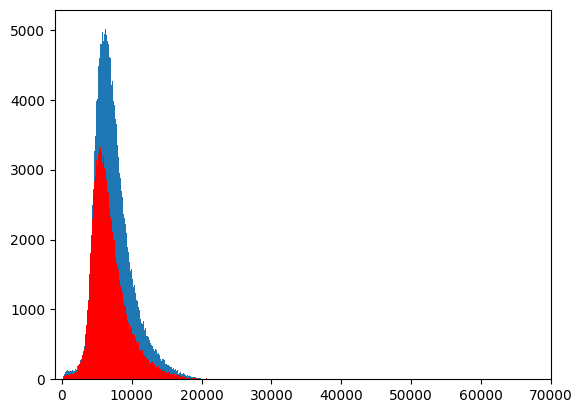

In [164]:
a = plt.hist(energy_protons, bins='auto')
b = plt.hist(energy_deuterons, bins='auto', color='red')
plt.xlim(-1000, 70000)
len(a[0])

In [ ]:
max(rr_deuterons);  

np.float64(67029.0)

In [157]:
max(energy_deuterons)

np.float64(66251.0)

In [158]:
max(rr_protons)

np.int64(194)

In [159]:
max(energy_protons)

np.float64(67029.0)

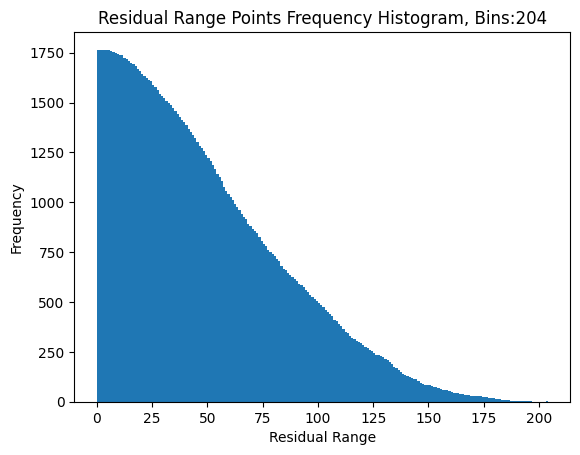

In [154]:
b=204
plt.hist(rr_deuterons, bins=b)
plt.xlabel('Residual Range')
plt.ylabel('Frequency')
plt.title(f'Residual Range Points Frequency Histogram, Bins:{b}')
plt.show()

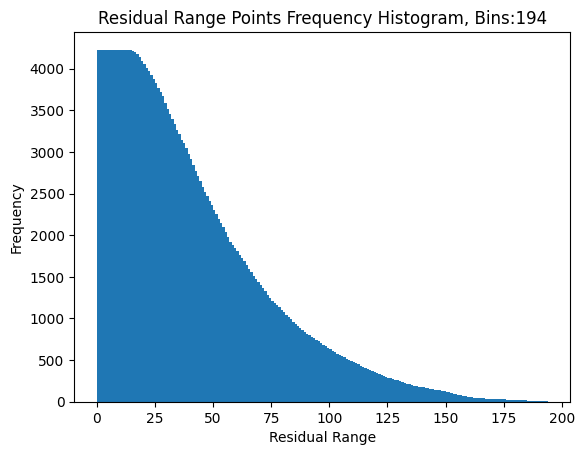

In [155]:
b=194
plt.hist(rr_protons, bins=b)
plt.xlabel('Residual Range')
plt.ylabel('Frequency')
plt.title(f'Residual Range Points Frequency Histogram, Bins:{b}')
plt.show()


(-1000.0, 70000.0)

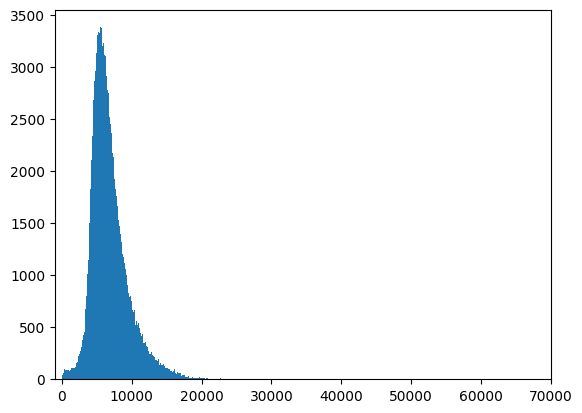

In [48]:
b = plt.hist(energy_deuterons, bins='auto')
plt.xlim(-1000, 70000)

<Figure size 1000x600 with 0 Axes>

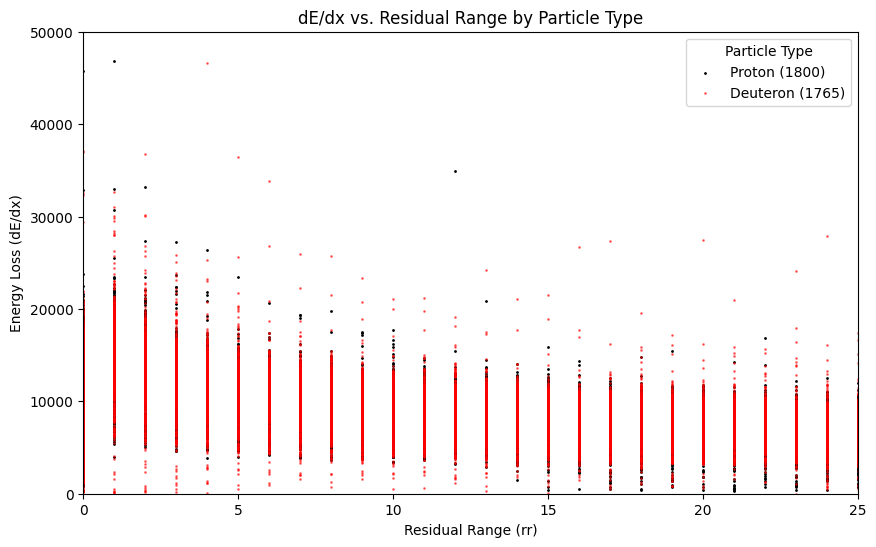

In [150]:
plt.figure(figsize=(10, 6))

coll = cleanclusters[cleanclusters['plane'] == 'collection']

plt.figure(figsize=(10, 6))

deuteron_mass = 1875.6  # MeV/c^2
proton_mass = 938.3     # MeV/c^2
mass_tol = 100           # MeV/c^2

# Filter for protons and deuterons
protons = coll[(coll['particle_type'] == 'proton') ] # & (np.abs(coll['beamline_mass'] - proton_mass) < mass_tol)
deuterons = coll[(coll['particle_type'] == 'deuteron')] # & (coll['height'] < 30) & (np.abs(coll['beamline_mass'] - deuteron_mass) < mass_tol)

protons = coll[(coll['particle_type'] == 'proton') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]
deuterons = coll[(coll['particle_type'] == 'deuteron') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]

protons = protons.sample(n= 1800)
deuterons = deuterons

# Plot protons (black)
rr_protons = np.concatenate(protons['rr'].values)
energy_protons = np.concatenate(protons['energy'].values)
plt.scatter(rr_protons, energy_protons, color='black', label=f'Proton ({len(protons)})', s=1)

# Plot deuterons (red)
rr_deuterons = np.concatenate(deuterons['rr'].values)
energy_deuterons = np.concatenate(deuterons['energy'].values)
plt.scatter(rr_deuterons, energy_deuterons, color='red', alpha=0.5, label=f'Deuteron ({len(deuterons)})', s=1)

plt.xlabel('Residual Range (rr)')
plt.ylabel('Energy Loss (dE/dx)')
plt.title('dE/dx vs. Residual Range by Particle Type')
plt.legend(title='Particle Type')
plt.ylim(0, 50000)
plt.xlim(0, 25)
plt.show()

In [148]:
proton_interest = coll[(coll['particle_type'] == 'proton') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]

(4226, 36)

In [144]:
proton_interest.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'p', 'm', 'beamline_mass', 'energy', 'rr',
       'normalised_e'],
      dtype='object')

In [ ]:
deuteron_interest = coll[(coll['particle_type'] == 'deuteron') & (coll['beamline_mass'] >= 1800) & ((coll['beamline_mass'] <= 2000)) & ((coll['p'] == 1))]
# deuteron_interest = coll[(coll['particle_type'] == 'deuteron') & (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]; proton_interest.shape # Wire [11, 35]
# deuteron_interest = coll[(coll['particle_type'] == 'deuteron') & ((coll['p'] == 1))] 

In [ ]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for i in range(len(proton_interest)): # len(proton_interest)
    
    row = proton_interest.iloc[i]

    event = Event(row['file_path'], row['event_index'], plot=False, threshold=15)

    fig, ax1 = plt.subplots(figsize=(12, 8))

    sns.heatmap(event.collection.T, ax=ax1, cmap='viridis', cbar_kws={'shrink': 0.8})
    ax1.invert_yaxis()

    start_wire = row['bbox_min_row'] 
    start_time = row['bbox_min_col']
    width = row['height']
    height = row['width']
    
    rect = Rectangle((start_wire, start_time), 
                     width, height, 
                     linewidth=1, 
                     edgecolor='red', 
                     facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title(f'Example Event After Cuts')
    plt.ylabel('Time Ticks')
    plt.xlabel('Wire')

    ax2 = inset_axes(ax1, width="40%", height="40%", loc='upper right')
    
    sns.heatmap(row['image_intensity'].T, ax=ax2, cbar=False)
    plt.xticks([])
    plt.yticks([])
    ax2.invert_yaxis()
    # ax2.set_title('Cluster', fontsize=10)

    
    plt.show()
    print(f"Event {i}")

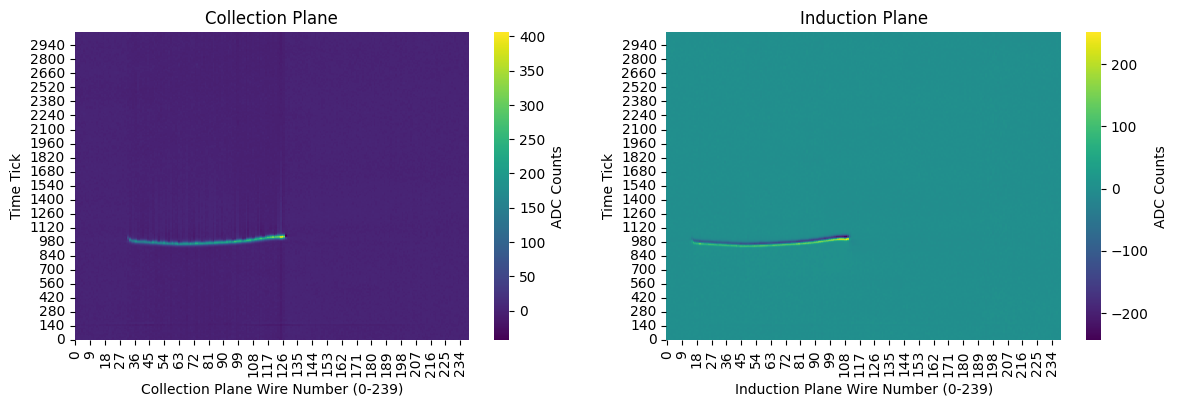

In [ ]:
event = Event(deuteron_interest.iloc[16]['file_path'], threshold=15)

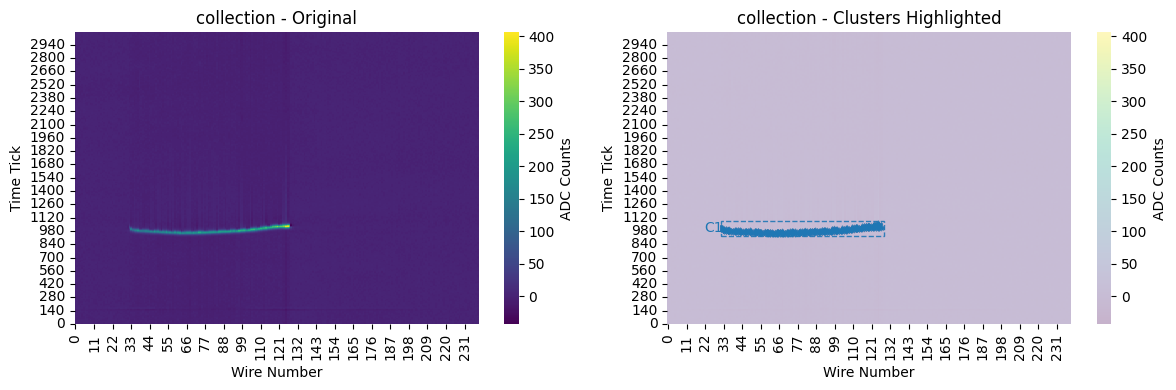

In [145]:
event.visualiseclusters(event.collection, regions=event.connectedcr, plane_name='collection', mode='highlight')